Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii
mask_indices_count:14946172


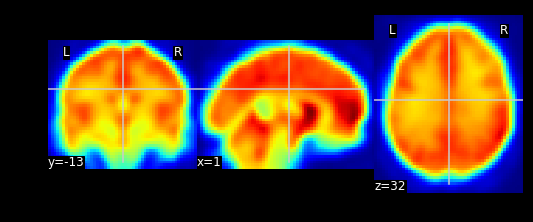

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from nilearn.image import math_img
import nibabel as nib
from nilearn.masking import compute_background_mask
from nilearn.masking import compute_epi_mask
from nilearn import plotting
from nilearn import image
import matplotlib.pyplot as plt
import copy

from ctensor import ccp_als, ccp_bcd, pyutils
from ctensor import dtensor, ktensor

import numpy as np
np.random.seed(0)

def get_mask(data, observed_ratio):
    
    if len(data.shape) == 3:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1],data.shape[2]) < observed_ratio).astype('int') 
    elif len(data.shape) == 4:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1],data.shape[2], data.shape[3]) < observed_ratio).astype('int') 
    elif len(data.shape) == 2:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1]) < observed_ratio).astype('int') 
    return mask_indices


def read_image_abs_path(path):
    img = nib.load(path)
    return img

def reconstruct_image_affine(img_ref, x_hat):
    result = nib.Nifti1Image(x_hat, img_ref.affine)
    return result

def reconstruct(x_hat,x_true, ten_ones, mask):
    x_reconstruct = np.multiply(mask,x_true) + np.multiply((ten_ones - mask), x_hat)
    return x_reconstruct

def tsc(x_hat,x_true, ten_ones, mask):
    nomin = np.linalg.norm(np.multiply((ten_ones - mask), (x_true - x_hat)))
    denom = np.linalg.norm(np.multiply((ten_ones - mask), x_true))
    score = nomin/denom
    return score 

subject_scan_path = "/work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii"
print ("Subject Path: " + str(subject_scan_path))

x_true_org = read_image_abs_path(subject_scan_path)
x_true_img = np.array(x_true_org.get_data())

observed_ratio = 0.20
missing_ratio = 1 - observed_ratio

mask_img = compute_epi_mask(x_true_org)
mask_img_data = np.array(mask_img.get_data())

mask_indices = get_mask(x_true_img, observed_ratio)
epi_mask = copy.deepcopy(mask_img_data)
    
mask_indices[epi_mask==0] = 1
mask_indices_count = np.count_nonzero(mask_indices==1)
print ("mask_indices_count:" + str(mask_indices_count))

norm_ground_truth = np.linalg.norm(x_true_img)
x_true_img = x_true_img * (1./norm_ground_truth)


norm_ground_truth = np.linalg.norm(x_true_img)
x_true_img = x_true_img * (1./norm_ground_truth)
ten_ones = np.ones_like(mask_indices)
x_train = copy.deepcopy(x_true_img)
x_train[mask_indices==0] = 0.0

x_init = copy.deepcopy(x_train)

x_org = reconstruct_image_affine(x_true_org, x_true_img)
x_org_img = image.index_img(x_org,1)
org_image = plotting.plot_epi(x_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [2]:
import ctensor
